# By Booking - All Chronics

Version2.1.4

Prepared by Alex Aw

20 Aug 2022



## Colab setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd '/content/drive/MyDrive/EBAC Capstone 2021-2022/Team_members/Alex/temp_debug'

## Import Library

In [3]:
import random 
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import numpy as np 
from numpy import unique
from numpy import where

import pickle
from pandas import to_pickle
from pandas import read_pickle

import io
from datetime import date

from itertools import compress

import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn import metrics 
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE 

import shap

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## Global Setting

In [5]:
# training file from prep notebook
TRAINING_FILE = "booking_train_data_final.pkl"

# Outlier removal : 0 not to remove, 1 to remove
INCL_IFOREST = 0

# SMOTE : 0 not activated, 1 activated
INCL_SMOTE = 0

# enter value 0<x<1 
TEST_SIZE = 0.3

# Choose either SVC or LR
SELECT_FR_MODEL_ALGO = "SVC"

## Helper Function

In [6]:
def run_model_N_eval(X_train, X_test, y_train, y_test, model="RF"):
    if model == "RF":
        model_def = RandomForestClassifier(max_depth=20, min_samples_split=20, random_state=42)
    elif model == "LR":
        model_def = LogisticRegression(random_state=42)
    elif model == "NB":
        model_def = MultinomialNB(random_state=42)
    elif model == "SVM":
        model_def = svm.SVC(C=1.0, kernel='linear', probability=True, random_state=42)
    elif model == "NLSVM":
        model_def = svm.SVC(C=1.0, kernel='rbf', probability=True, random_state=42)
    elif model == "XGB":
        model_def = XGBClassifier(max_depth=3, n_estimators=100, 
                                  reg_alpha=0, reg_lambda=1, random_state=42)
    else:
        print("WRONG model type specified")
        return None
          
    # Pipeline
    
    if SELECT_FR_MODEL_ALGO == "SVC":
        clf = Pipeline([('feature_selection', SelectFromModel(LinearSVC(random_state=42))), 
                        ('clf', model_def)])
    elif SELECT_FR_MODEL_ALGO == "LR":
        clf = Pipeline([('feature_selection', SelectFromModel(LogisticRegression(random_state=42))), 
                        ('clf', model_def)])
    else:
        print("Please correct the decision for SELECT_FR_MODEL_ALGO, shd be either SVC or LR")

    # Fit Model
    clf.fit(X_train,y_train ) 

    # Prediction
    predicted_test = clf.predict(X_test)
    predicted_train = clf.predict(X_train)
    
    # Generate Confusion Matrix
    cf_train_matrix = metrics.confusion_matrix(y_train, predicted_train)
    cf_test_matrix = metrics.confusion_matrix(y_test, predicted_test)
    
    print("Model: ", model, "\n")
    print("Labels:", y_train.unique(), "\n")
    
    print("\n","#"*100)

    print("For Training Data:")
    print(cf_train_matrix, "\n")
    %matplotlib inline
    plt.figure(figsize=(10,8))
    sns.heatmap(cf_train_matrix, annot=True, fmt='d', vmin=0, vmax=y_train.shape[0]/len(y_train.unique()), cmap="Blues")
    plt.title("Training Data Confusion Matrix Heatmap")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()
    
    print(metrics.classification_report(y_train, predicted_train, digits=4, target_names=target_names), "\n" )
    
    print("\n","#"*100)

    print("For Testing Data:")
    print(cf_test_matrix, "\n")
    %matplotlib inline
    plt.figure(figsize=(10,8))
    sns.heatmap(cf_test_matrix, annot=True, fmt='d', vmin=0, vmax=y_test.shape[0]/len(y_train.unique()), cmap="Blues")
    plt.title("Testing Data Confusion Matrix Heatmap")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()
    
    print(metrics.classification_report(y_test, predicted_test,  digits=4, target_names=target_names), "\n" )

    print("\n","#"*100)
    
    return clf.named_steps['clf'], clf.named_steps['feature_selection']

In [7]:
def make_shap_waterfall_plot(shap_values, features, feature_names, num_display=20):
    column_list = feature_names
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

## Import Data

In [8]:
# Check exported data
df = read_pickle(TRAINING_FILE)

In [9]:
# removal listed columns
df = df.drop(['diagnosis_code_list', 'diagnosis_list', 'chronic_list', 'medicationID_list', 'medicationName_list',
        'medQuantity_list', 'medAndQuan_list', 'SymptomID_list', 'SymptomName_list'], axis=1)

In [10]:
pd.set_option('display.max_rows', None)
df.head().transpose()

,0,1,2,3,4
booking_id,23800D32-7520-4D21-83A5-80A378443767,8D2D1C67-CB20-4453-A70F-503DFCF506F8,0EB28D3C-F967-476F-BA26-EC89C53F8297,64005993-7B8D-4AC6-B184-2BC260995C36,04DF2127-C262-493C-A7BE-1C5F33F8B378
mem_id,3499A82B-4260-4447-9CDC-152262D968E5,3499A82B-4260-4447-9CDC-152262D968E5,B86F2734-B200-4B16-BF6B-7B873EA651A4,B86F2734-B200-4B16-BF6B-7B873EA651A4,B86F2734-B200-4B16-BF6B-7B873EA651A4
doctor_id,B045D798-DC64-4CA9-9FC4-28691E82EB72,77EFF8BB-D181-4BFB-90A4-75FA494F4BBB,EB022DC9-CBDB-4E11-950B-ECBB2287E2C3,EB022DC9-CBDB-4E11-950B-ECBB2287E2C3,7C2FDBF3-2942-47AD-AE19-ECC6F4E115E9
consult_waived_reason,NA,NA,NA,NA,NA
is_mc_issued,0,0,1,1,1
mc_days,0.0,0.0,1.0,1.0,1.0
is_referral_letter_issued,0,1,0,0,0
booking_timestamp,2021-05-07 12:37:02,2021-04-26 16:44:15,2021-08-23 19:32:00,2021-08-01 16:33:53,2021-02-22 20:03:45
gender,Female,Female,Female,Female,Female
birth_year,2000,2000,1983,1983,1983


In [11]:
print("Shape of data: ", df.shape)

Shape of data:  (10221, 145)


## Basic Investigation¶

In [12]:
# print("Data Header")
# df.head(5).transpose()

In [13]:
# # majority NA, to be dropped.
# df['consult_waived_reason'].isna().sum()

In [14]:
# df.nunique()

In [15]:
# print("Basic Data structure Info")
# df.info("deep")

In [16]:
# df['age_yr'].unique()

In [17]:
# print("Basic Data Summary")
# df.describe().transpose()

In [18]:
# df.isnull().sum()

In [19]:
# df.duplicated().sum()

In [20]:
all_list = df.columns.tolist()

In [21]:
#[TODO] EDIT TO INCLUDE CATEGORICAL INPUT TO CONSIDER
cat_list = ['gender',
           'doctor_id',
           'consult_waived_reason',
           ]

In [22]:
df[cat_list] = df[cat_list].astype("category")

In [23]:
# Currently type as float
int_list = ['mc_days', 
            'count_diagnosis', 
            'count_chronic', 
            'count_medication', 
            'count_repeatmed', 
            'count_SymID', 
            'age_yr']

In [24]:
#convert to integer
df[int_list] = df[int_list].astype("int")

In [25]:
#[TODO] EDIT WHERE NEC
exc_list = ['booking_id', 
            'mem_id', 
            'birth_year', 
            'booking_timestamp',
            'count_chronic',
            'chronic_NoneChronic', 
            'chronic_Atopic dermatitis',
            'chronic_Migraine',
            'chronic_Vasomotor and allergic rhinitis',
            'chronic_Gastro-oesophageal reflux disease',
            'chronic_Hypertension',
            'chronic_Asthma',
            'chronic_Hyperlipidaemia',
            'chronic_Thyroid',
            'chronic_Diabetes',
            'chronic_Gout',
            'Target_chronic',
            'symp_chronic medicine top-up', 
            'symp_chronic illness management',
            'consult_waived_reason',
            
            ## diagnostics directly identifying chronics
            'diag_J30',  #Vasomotor and allergic rhinitis
            'diag_K21',  #Gastro-esophageal reflux disease
            'diag_G43',  #Migraine
            'diag_L20',  #Atopic dermatitis
            'diag_M10',  #Gout
            'diag_I10', 'diag_R03', #hypertension
            'diag_J45',  #Asthma
            'diag_E11',  #Diabetes
            'diag_E78',  #hypercholesterolemia, hyperglyceridemia, Hyperlipidemia (high cholesterol), Hyperchylomicronemia
            'diag_E05', 'diag_E03','diag_E04'   #thyroid
            ## end of diagnostics directly identifying chronics
            
           ]
            


In [26]:
select_col = [x for x in all_list if x not in exc_list]  #[TODO] EDIT IF NEC

In [27]:
num_list = [x for x in select_col if x not in cat_list]  #[TODO] EDIT IF NEC

## One Hot encoding

In [28]:
enc_df = pd.get_dummies(df[cat_list])

In [29]:
# Drop "gender_Unknown"
drop_oneHot = ["gender_Female", "gender_Male"]

In [30]:
enc_df = enc_df[drop_oneHot]   #[TODO] TO EDIT AND DROP ONE CATEGORY LEVEL FOR ONE-HOT

In [31]:
df.info("deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10221 entries, 0 to 10220
Data columns (total 145 columns):
 #    Column                                     Dtype         
---   ------                                     -----         
 0    booking_id                                 object        
 1    mem_id                                     object        
 2    doctor_id                                  category      
 3    consult_waived_reason                      category      
 4    is_mc_issued                               int64         
 5    mc_days                                    int32         
 6    is_referral_letter_issued                  int64         
 7    booking_timestamp                          datetime64[ns]
 8    gender                                     category      
 9    birth_year                                 int64         
 10   count_diagnosis                            int32         
 11   count_chronic                              int32    

## Define input and output

In [32]:
# merge with numerical df for input
X = df[num_list].join(enc_df)

In [33]:
# Define the Target
y = df["Target_chronic"]  #[TODO] TO EDIT AND DEFINE TARGET LABEL 

In [34]:
# Check input variable names
feature_names = X.columns.tolist()

In [35]:
# EXPORT PICKLE
# export training Feature List for deployment
PKL_ALL_FEATURE_FILENAME = "booking_model_all_featurelist.pkl"
with open(PKL_ALL_FEATURE_FILENAME, "wb") as file:
    pickle.dump(feature_names, file)

## Train Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [37]:
y.value_counts()

0    8734
1    1487
Name: Target_chronic, dtype: int64

In [38]:
y.value_counts(normalize=True)[1] * 100

14.548478622443989

## Oversample for Training
TO INCLUDE IF DATA TARGET CLASS TOO IMBALANCE

In [39]:
print(f'''Shape of X train without balancing: {X_train.shape}''')
print(f'''% Positive class of X train without balancing = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}''')

Shape of X train without balancing: (7154, 114)
% Positive class of X train without balancing = 14.55


In [40]:
# OVERSAMPLE_RATIO set here is to oversample the minority class with SMOTE 
# it corresponds to the desired ratio of
# number of samples in minority class over number of samples the majority class after resampling.
# OVERSAMPLE_RATIO = 0.3
if INCL_SMOTE == 1:
    sm = SMOTE(random_state=42, sampling_strategy=OVERSAMPLE_RATIO)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print(f'''Shape of X train after SMOTE: {X_train.shape}''')
    print(f'''% Positive class of X train after SMOTE = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}''')
else: 
    print("SMOTE not included.")

SMOTE not included.


In [41]:
print("SMOTE over-sampling is not done for Test data")
print(f'''Shape of X Test after SMOTE: {X_test.shape}''')
print(f'''% Positive class f X Test before SMOTE = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

SMOTE over-sampling is not done for Test data
Shape of X Test after SMOTE: (3067, 114)
% Positive class f X Test before SMOTE = 14.54


## Remove Outliers

Isolation Forest, or iForest for short, is a tree-based anomaly detection algorithm.

It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space.

The method is based on two anomalies’ quantitative properties:

i) they are the minority consisting of fewer instances and

ii) they have attribute-values that are very different from those of normal instances. The scikit-learn library provides an implementation of Isolation Forest in the IsolationForest class.

In [42]:
# identify outliers in the training dataset

if INCL_IFOREST ==1: 
    iso = IsolationForest(contamination=0.1,random_state= 0)
    yhat = iso.fit_predict(X_train)

    # select all rows that are not outliers
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    print("No of outliers marked: ")
    sum(yhat == -1)
    
    # summarize the shape of the updated training dataset
    print("Shape of processed dataset, X_train vs y_train after removing outliers")
    print(X_train.shape, y_train.shape)

## Standardized Data

In [43]:
sc =  StandardScaler()
# Fit and Transform the training dataset
print("Fit and Transform the training dataset")
X_train = sc.fit_transform(X_train)

Fit and Transform the training dataset


In [44]:
# Transform the testing dataset
print("Transform the testing dataset (no fitting)")
X_test = sc.transform (X_test)

Transform the testing dataset (no fitting)


In [45]:
# EXPORT PICKLE
PKL_STANDARDSCALER_FILENAME = "booking_model_all_standardard_scaler.pkl"
with open(PKL_STANDARDSCALER_FILENAME, "wb") as file:
    pickle.dump(sc, file)

## Model Selection

In [46]:
target_names = ['Non-Chronic', 'Chronic']   #Define Target Names

### Logistic Model

Model:  LR 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[5949  164]
 [ 522  519]] 



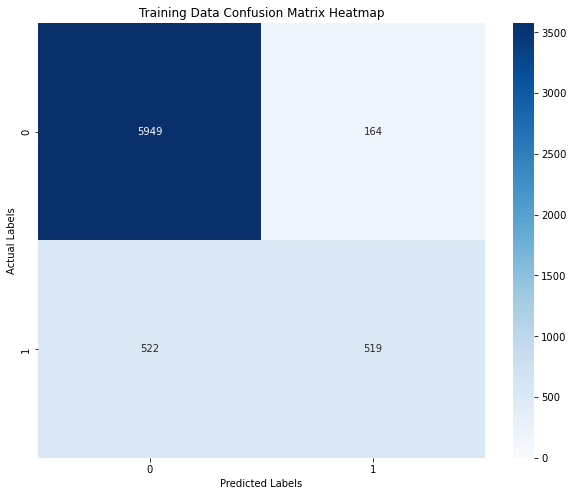

              precision    recall  f1-score   support

 Non-Chronic     0.9193    0.9732    0.9455      6113
     Chronic     0.7599    0.4986    0.6021      1041

    accuracy                         0.9041      7154
   macro avg     0.8396    0.7359    0.7738      7154
weighted avg     0.8961    0.9041    0.8955      7154
 


 ####################################################################################################
For Testing Data:
[[2555   66]
 [ 232  214]] 



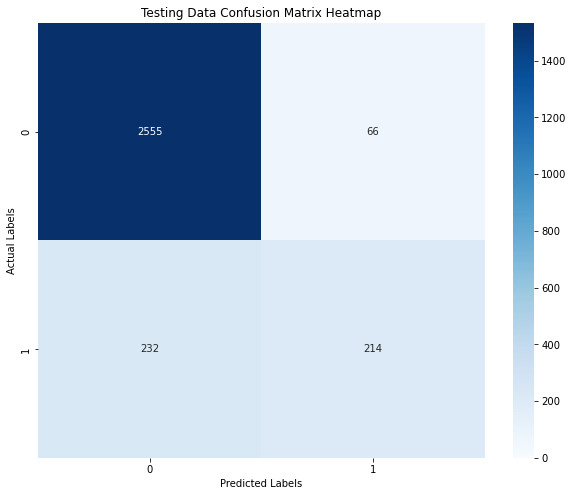

              precision    recall  f1-score   support

 Non-Chronic     0.9168    0.9748    0.9449      2621
     Chronic     0.7643    0.4798    0.5895       446

    accuracy                         0.9028      3067
   macro avg     0.8405    0.7273    0.7672      3067
weighted avg     0.8946    0.9028    0.8932      3067
 


 ####################################################################################################


In [47]:
LR_model, LR_selectFeature = run_model_N_eval(X_train, X_test, y_train, y_test, model="LR")

### Support Vector Machine (Linear)

Model:  SVM 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[5923  190]
 [ 506  535]] 



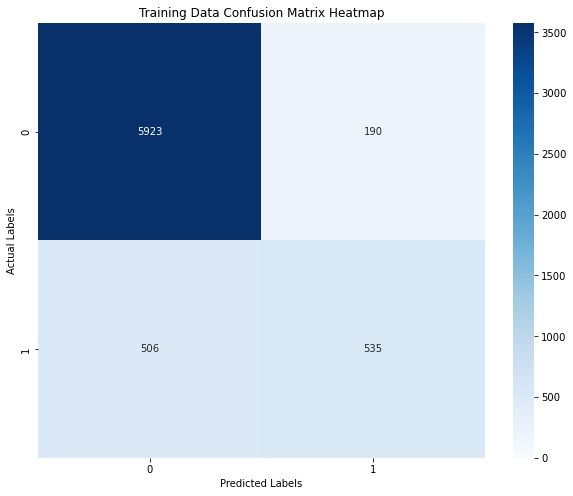

              precision    recall  f1-score   support

 Non-Chronic     0.9213    0.9689    0.9445      6113
     Chronic     0.7379    0.5139    0.6059      1041

    accuracy                         0.9027      7154
   macro avg     0.8296    0.7414    0.7752      7154
weighted avg     0.8946    0.9027    0.8952      7154
 


 ####################################################################################################
For Testing Data:
[[2548   73]
 [ 221  225]] 



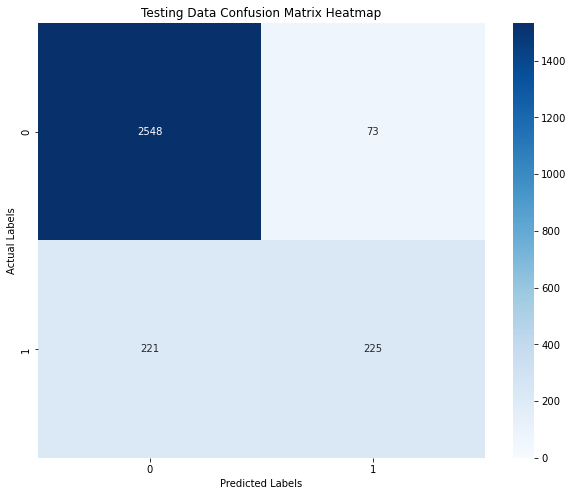

              precision    recall  f1-score   support

 Non-Chronic     0.9202    0.9721    0.9455      2621
     Chronic     0.7550    0.5045    0.6048       446

    accuracy                         0.9041      3067
   macro avg     0.8376    0.7383    0.7751      3067
weighted avg     0.8962    0.9041    0.8959      3067
 


 ####################################################################################################


In [48]:
SVM_model, SVM_selectFeature = run_model_N_eval(X_train, X_test, y_train, y_test, "SVM")

### Support Vector Machine (Non-Linear)

Model:  NLSVM 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[5872  241]
 [ 449  592]] 



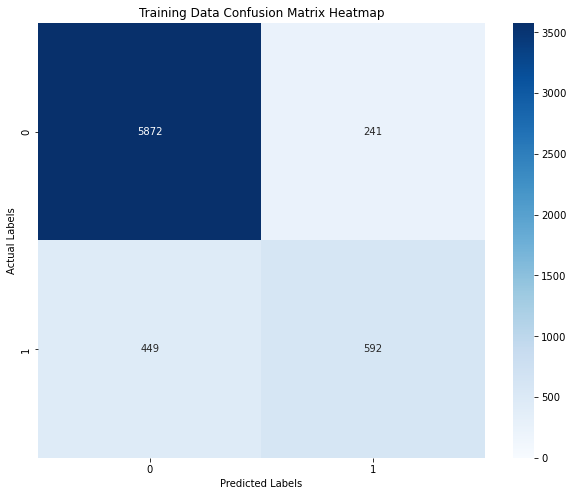

              precision    recall  f1-score   support

 Non-Chronic     0.9290    0.9606    0.9445      6113
     Chronic     0.7107    0.5687    0.6318      1041

    accuracy                         0.9036      7154
   macro avg     0.8198    0.7646    0.7882      7154
weighted avg     0.8972    0.9036    0.8990      7154
 


 ####################################################################################################
For Testing Data:
[[2531   90]
 [ 211  235]] 



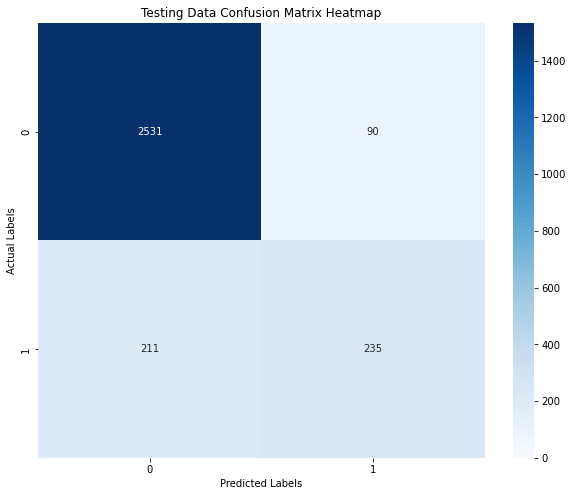

              precision    recall  f1-score   support

 Non-Chronic     0.9230    0.9657    0.9439      2621
     Chronic     0.7231    0.5269    0.6096       446

    accuracy                         0.9019      3067
   macro avg     0.8231    0.7463    0.7767      3067
weighted avg     0.8940    0.9019    0.8953      3067
 


 ####################################################################################################


In [49]:
NLSVM_model, NLSVM_selectFeature = run_model_N_eval(X_train, X_test, y_train, y_test, "NLSVM")

### Random Forest

Model:  RF 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[6033   80]
 [ 586  455]] 



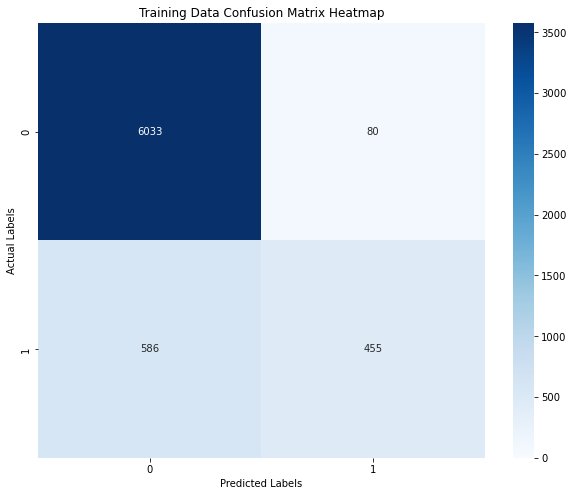

              precision    recall  f1-score   support

 Non-Chronic     0.9115    0.9869    0.9477      6113
     Chronic     0.8505    0.4371    0.5774      1041

    accuracy                         0.9069      7154
   macro avg     0.8810    0.7120    0.7626      7154
weighted avg     0.9026    0.9069    0.8938      7154
 


 ####################################################################################################
For Testing Data:
[[2571   50]
 [ 264  182]] 



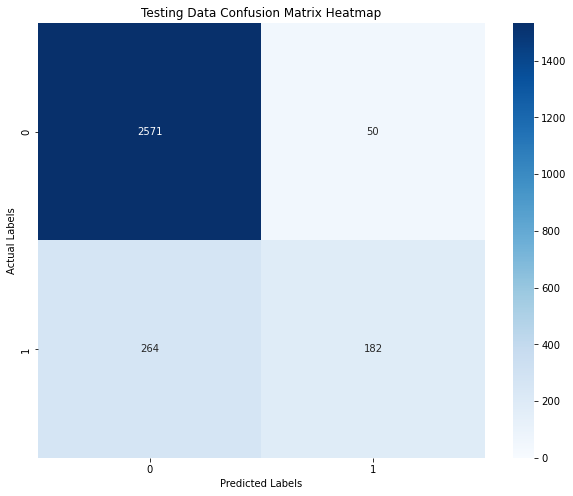

              precision    recall  f1-score   support

 Non-Chronic     0.9069    0.9809    0.9424      2621
     Chronic     0.7845    0.4081    0.5369       446

    accuracy                         0.8976      3067
   macro avg     0.8457    0.6945    0.7397      3067
weighted avg     0.8891    0.8976    0.8835      3067
 


 ####################################################################################################


In [50]:
RF_model, RF_selectFeature = run_model_N_eval(X_train, X_test, y_train, y_test, "RF")

### XGBoost

Model:  XGB 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[6008  105]
 [ 577  464]] 



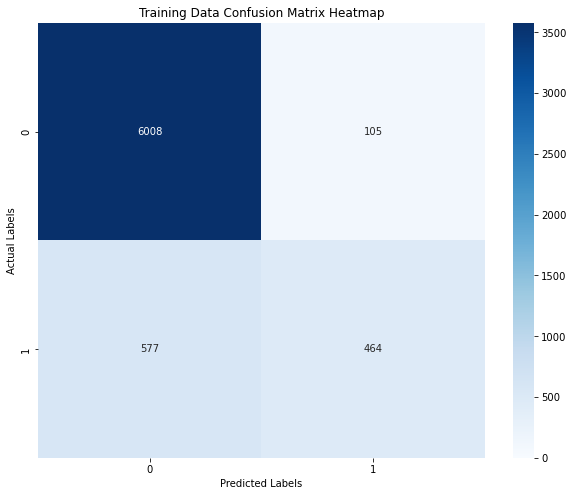

              precision    recall  f1-score   support

 Non-Chronic     0.9124    0.9828    0.9463      6113
     Chronic     0.8155    0.4457    0.5764      1041

    accuracy                         0.9047      7154
   macro avg     0.8639    0.7143    0.7613      7154
weighted avg     0.8983    0.9047    0.8925      7154
 


 ####################################################################################################
For Testing Data:
[[2569   52]
 [ 258  188]] 



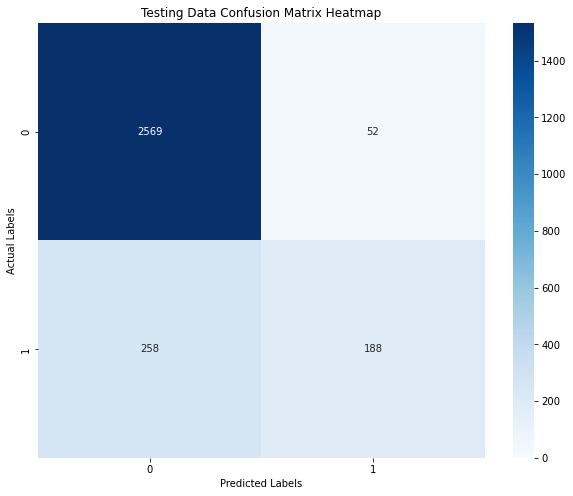

              precision    recall  f1-score   support

 Non-Chronic     0.9087    0.9802    0.9431      2621
     Chronic     0.7833    0.4215    0.5481       446

    accuracy                         0.8989      3067
   macro avg     0.8460    0.7008    0.7456      3067
weighted avg     0.8905    0.8989    0.8857      3067
 


 ####################################################################################################


In [51]:
XGB_model, XGB_selectFeature = run_model_N_eval(X_train, X_test, y_train, y_test, "XGB")

## Feature Selected

In [52]:
# EXPORT PICKLE
PKL_SELECT_MODEL_FILENAME = "booking_model_all_selectfeature.pkl"
with open(PKL_SELECT_MODEL_FILENAME, "wb") as file:
    pickle.dump(LR_selectFeature, file)

In [53]:
X_newTest_LR = LR_selectFeature.transform(X_test)
X_newTrain_LR = LR_selectFeature.transform(X_train)
feature_idx_LR = LR_selectFeature.get_support()
final_selectList_LR = list(compress(feature_names, feature_idx_LR))
len(final_selectList_LR)

42

In [54]:
X_newTest_SVM = SVM_selectFeature.transform(X_test)
X_newTrain_SVM = SVM_selectFeature.transform(X_train)
feature_idx_SVM = SVM_selectFeature.get_support()
final_selectList_SVM = list(compress(feature_names, feature_idx_SVM))
len(final_selectList_SVM)

42

In [55]:
X_newTest_NLSVM = NLSVM_selectFeature.transform(X_test)
X_newTrain_NLSVM = NLSVM_selectFeature.transform(X_train)
feature_idx_NLSVM = NLSVM_selectFeature.get_support()
final_selectList_NLSVM = list(compress(feature_names, feature_idx_NLSVM))
len(final_selectList_NLSVM)

42

In [56]:
X_newTest_RF = RF_selectFeature.transform(X_test)
X_newTrain_RF = RF_selectFeature.transform(X_train)
feature_idx_RF = RF_selectFeature.get_support()
final_selectList_RF = list(compress(feature_names, feature_idx_RF))
len(final_selectList_RF)

42

In [57]:
X_newTest_XGB = XGB_selectFeature.transform(X_test)
X_newTrain_XGB = XGB_selectFeature.transform(X_train)
feature_idx_XGB = XGB_selectFeature.get_support()
final_selectList_XGB = list(compress(feature_names, feature_idx_XGB))
len(final_selectList_XGB)

42

## Export Model

In [58]:
# EXPORT PICKLE
#Export LR_model for deployment
PKL_LR_MODEL_FILENAME = "booking_model_all_logistic.pkl"
with open(PKL_LR_MODEL_FILENAME, "wb") as file:
    pickle.dump(LR_model, file)

In [59]:
# EXPORT PICKLE
#Export SVM_model for deployment
PKL_SVM_MODEL_FILENAME = "booking_model_all_svm.pkl"
with open(PKL_SVM_MODEL_FILENAME, "wb") as file:
    pickle.dump(SVM_model, file)

In [60]:
# EXPORT PICKLE
#Export Non-linear SVM_model for deployment
PKL_NLSVM_MODEL_FILENAME = "booking_model_all_nonlinear_svm.pkl"
with open(PKL_NLSVM_MODEL_FILENAME, "wb") as file:
    pickle.dump(NLSVM_model, file)

In [61]:
# EXPORT PICKLE
#Export RF_model for deployment
PKL_RF_MODEL_FILENAME = "booking_model_all_randomforest.pkl"
with open(PKL_RF_MODEL_FILENAME, "wb") as file:
    pickle.dump(RF_model, file)

In [62]:
# EXPORT PICKLE
#Export XGB_model for deployment
PKL_XGB_MODEL_FILENAME = "booking_model_all_xgb.pkl"
with open(PKL_XGB_MODEL_FILENAME, "wb") as file:
    pickle.dump(XGB_model, file)

## ROC

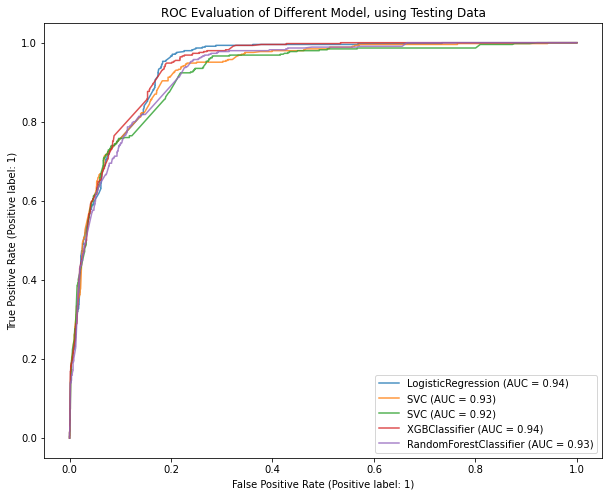

In [63]:
%matplotlib inline
plt.figure(figsize=(10,8))
ax = plt.gca()
LR_disp = RocCurveDisplay.from_estimator(LR_model, X_newTest_LR, y_test, ax=ax, alpha=0.8)
SVM_disp = RocCurveDisplay.from_estimator(SVM_model, X_newTest_SVM, y_test, ax=ax, alpha=0.8)
NLSVM_disp = RocCurveDisplay.from_estimator(NLSVM_model, X_newTest_NLSVM, y_test, ax=ax, alpha=0.8)
XGB_disp = RocCurveDisplay.from_estimator(XGB_model, X_newTest_XGB, y_test, ax=ax, alpha=0.8)
RF_disp = RocCurveDisplay.from_estimator(RF_model, X_newTest_RF, y_test, ax=ax, alpha=0.8)
plt.title("ROC Evaluation of Different Model, using Testing Data")
plt.show()

@end